# Prototyping

This notebook is my early thoughts and experiments on this project.

Goal: make a license plate that I wouldn't have recognized recognizable.

### Possible datasets

1. https://www.kaggle.com/andrewmvd/car-plate-detection
    - Public domain (asks for credit)
    - 433
    - Quality maybe 7/10 (some images have plates small or missing)
1. https://www.kaggle.com/thamizhsterio/indian-license-plates
    - No license found--might be ok for personal use
    - 10000 (!)
    - Quality 9 (actually cropped, which is nice)
1. https://www.kaggle.com/mrugankray/license-plates?
    - No license found--hmm
    - 200 something
    - Quality 6
1. https://www.kaggle.com/pcmill/license-plates-on-vehicles?select=HCZyJ9TY6QizRhqI.jpeg
    - Public domain, no attribution listed
    - 399
    - Quality 7
1. http://www.zemris.fer.hr/projects/LicensePlates/english/results.shtml
    - License unclear
    - 500 images
    - Quality 10 (really good pictures; all look to have been taken by the student)

**I think I'll use 1, 4, and 5.**

In [3788]:
%matplotlib inline
import os
from time import time
from PIL import Image, ImageEnhance
from numpy import random
from matplotlib.pyplot import imshow
import cairo
import numpy as np
from IPython.display import Image as IImage
from fastai.vision import parallel

## Image degrading

In [13]:
!ls

prototyping.ipynb


In [1]:
import torchvision

In [15]:
base_path = '../data'

In [17]:
train_set = torchvision.datasets.ImageFolder(root=os.path.join(base_path, 'train'))

Directory structure:

- train
    - original
    - degraded
- valid
    - original
    - degraded

In [144]:
train_set.imgs[:10]

[('../data/train/original/06R3iOa3bATCEVXz.jpg', 0),
 ('../data/train/original/09Y0lBpIJ7tIplW2.jpg', 0),
 ('../data/train/original/0CDTBhPMJc1ZUf5S.jpg', 0),
 ('../data/train/original/0ETtCXFcSCgOLNyH.jpg', 0),
 ('../data/train/original/0KNVFEUQVov26wku.jpg', 0),
 ('../data/train/original/0WLUDeUFaBbyfqJK.jpg', 0),
 ('../data/train/original/0X1c3Yo2gzP46bNb.jpg', 0),
 ('../data/train/original/0X5bZskpz2fUUYVJ.jpg', 0),
 ('../data/train/original/0txdwQJANA69veu6.jpg', 0),
 ('../data/train/original/0u8gq295rn7kSbrq.jpg', 0)]

In [1092]:
img_size = 96
def degrade_image(input, i=None):  
    img = Image.open(input)
    w, h = img.size
    ratio = min(img_size / w, img_size / h)
    target_size = int(w*ratio),int(h*ratio)
    img = img.resize(target_size, resample=Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    img.save('./test-degrade.jpg', quality=q)

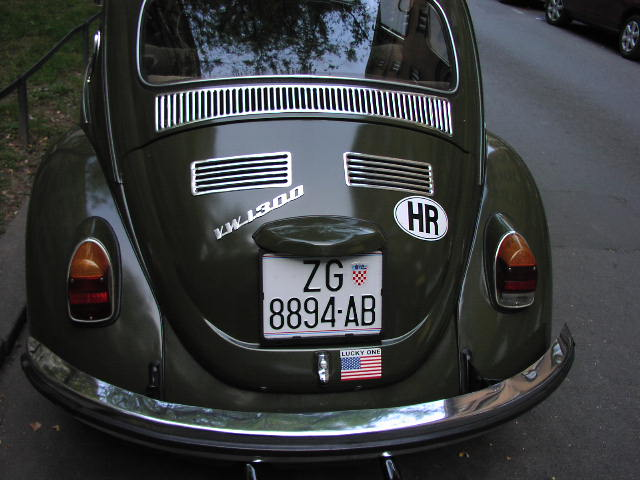

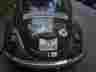

In [1584]:
# Test things out
max_width=500
rand_idx = random.randint(0, len(train_set.imgs))
degrade_image(train_set.imgs[rand_idx][0])
display(IImage(train_set.imgs[rand_idx][0], width=max_width, height=max_width))
display(IImage('test-degrade.jpg', width=max_width, height=max_width))

**Problem: the original problem was for upscaling cropped licenses.**

Synthetic data might be a good option here. What's worth weighing is whether the extra effort of creating 2D license plate images (or 3D) is a good investment for whatever we gain. If we decide to go that route, there could be several options:

- Processing
    - Has 2D, 3D options (incl. with lighting--possibly for glare)
    - Can save entire canvas: https://processing.org/reference/save_.html
    - How we might do this:
        - Create a 2D texture for the license plate
            - Get a bunch of license plate blank backgrounds--at least one for every state and maybe some from out of the country
            - Find a few different fonts that might fit on license plates
            - Composite the two together, making sure that text generation is parameterized such that it never overflows 
        - Project that texture onto a plane and rotate it randomly but within a range where the numbers are always visible to the user
        - Draw a random imagenet image as the background to get the license plate in context
            - Or maybe a picture of a car? That might make more sense. Are there any massive public domain car datasets?
        - Light the scene such that
            - The brightness of the light is the mean (or median?) value of the background and maybe the hue matches as well, but the license plate can always be seen
                - Note that we want to have a variety of different lighting conditions to train on
            - There is a probability, when the scene is light enough, that the letters on the license plate will be partially obsured. This could be a combination of two things:
                - The specularity of the plate
                - The brightness and direction of the light
        - Translate the entire scene parallel to the viewer
            - Note that we don't need to always keep the entire license plate in frame, so some slop here would be acceptable
- Cario library for drawing plates

What I'm attempting to make here is something that can generate a halfway-convincing license plate in 2d.

In [1845]:
# TODO (maybe): Might be nice to have a neural network that comes up with these too

def alphabet_serial_gen():
    return chr(ord("A") + random.randint(26))

def number_serial_gen():
    return str(random.randint(10))

def alphanumeric_serial_gen():
    return random.choice([alphabet_serial_gen(), number_serial_gen()])

separators = ['-', '·']

def generate_plate_serial():
    num_chunks = random.randint(3) + 1
    serial_string = ""
    seperator = random.choice(separators)
    
    for i in range(num_chunks):
        chunk_generator = random.choice([alphabet_serial_gen, number_serial_gen, alphanumeric_serial_gen])
        chunk_len = random.randint(2) + (5 - num_chunks)
        serial_string += "".join([chunk_generator() for _ in range(chunk_len)])
        if i < num_chunks - 1:
            serial_string += random.choice([' ', seperator], p=[0.4, 0.6])
    
    return serial_string

    
generate_plate_serial()

'9G6-72-59'

In [3938]:
side_length = 2000
radius = 20/side_length
padding = 0.02
font_choices = [
    "Heavy Equipment",
    "Ubuntu Mono",
    "Ubuntu",
    "Lato",
    "JetBrains Mono",
    "Times New Roman",
    "FE-Font"
]
font_color_choices = [
    (1, 1, 1),
    (0, 0, 0),
    (1, 1, 0),
]
graphic_types = [
    "circle",
    "rectangle"
]

def generate_plate_params():
    return {
        "text": generate_plate_serial(),
        "padding": [(random.rand() * 0.06) + 0.01 for _ in range(2)],
        "font": random.choice(font_choices),
        "bold": random.rand() >= 0.3,
        "radius": random.rand() * 0.03
    }

def generate_plate(params, highlighted, dest):
    global side_length
    with cairo.ImageSurface(cairo.Format.ARGB32, side_length, side_length) as surface:
        context = cairo.Context(surface)

        context.scale(side_length, side_length)
        context.set_line_width(0.01)

        #context.rectangle(x, y, width, height)
        #context.stroke()
        context.select_font_face(params["font"], cairo.FONT_SLANT_NORMAL, 
        cairo.FONT_WEIGHT_BOLD if params["bold"] else cairo.FONT_WEIGHT_NORMAL)

        context.set_font_size(0.1)

        (tx, ty, tw, th, tdx, tdy) = context.text_extents(params["text"])

        w_padding, h_padding = params["padding"]
        width, height = tw + w_padding * 2, th + h_padding * 2

        x, y, x1, y1 = 0.5 - width/2, 0.5 - height/2, 0.5 + width/2, 0.5 + height/2

        is_white = False

        if highlighted:
            context.set_source_rgba(1, 1, 1, 1)
        else:
            if random.rand() < 0.8:
                if random.rand() < 0.5:
                    # Linear gradient
                    gradient = cairo.LinearGradient(random.rand(), random.rand(), random.rand(), random.rand())
                    gradient.add_color_stop_rgba(0, random.rand(), random.rand(), random.rand(), 1)
                    gradient.add_color_stop_rgba(1, random.rand(), random.rand(), random.rand(), 1)
                    context.set_source(gradient)
                else:
                    # Solid color
                    context.set_source_rgba(random.rand(), random.rand(), random.rand(), 1)
            else:
                # White
                is_white = True
                context.set_source_rgba(0.95, 0.95, 0.95, 1)
                


        def draw_rounded_rectangle(radius): 
            context.new_sub_path()
            context.arc(x + radius, y + radius, radius, np.pi * 1, np.pi * 1.5)
            context.arc(x1 - radius, y + radius, radius, np.pi * 1.5, np.pi * 0)
            context.arc(x1 - radius, y1 - radius, radius, np.pi * 0, np.pi * 0.5)
            context.arc(x + radius, y1 - radius, radius, np.pi * 0.5, np.pi * 1)
            context.close_path()


        draw_rounded_rectangle(params["radius"])
        context.fill()
        
        if not highlighted:
            # Abstract graphics pass
            with cairo.ImageSurface(cairo.Format.ARGB32, side_length, side_length) as graphics_surface:
                graphics_context = cairo.Context(graphics_surface)
                graphics_context.scale(side_length, side_length)
                element_count = random.randint(10)
                for i in range(element_count):
                    graphic_type = random.choice(graphic_types)
                    gx = x + (random.rand() * width)
                    gy = y + (random.rand() * height)
                    graphics_context.set_source_rgba(*[random.rand() for _ in range(4)])
                    
                    if graphic_type == "rectangle":
                        gw, gh = [(random.rand() * 0.5) + 0.01 for _ in range(2)]
                        
                        graphics_context.save()
                        graphics_context.translate(gx, gy)
                        graphics_context.rotate(np.pi * 2 * random.rand())
                        graphics_context.rectangle(-gw/2, -gh/2, gw, gh)
                        graphics_context.restore()
                    elif graphic_type == "circle":
                        c_radius = (random.rand() * 0.5) + 0.01
                        graphics_context.arc(gx, gy, c_radius, 0, np.pi * 2)
                    
                    graphics_context.set_line_width((random.rand() * 0.03) + 0.01)
                    random.choice([graphics_context.fill, graphics_context.stroke])()
                
                context.save()
                context.scale(1/side_length, 1/side_length)
                context.set_source_surface(graphics_surface)
                context.scale(side_length, side_length)
                draw_rounded_rectangle(params["radius"])

                context.clip()
                context.paint()
                context.restore()
                # context.restore()
        
        if highlighted or random.rand() < 0.5:
            context.set_line_width(0.01 if highlighted else random.rand() * 0.02)
            context.set_source_rgba(*((0,0,0) if highlighted else (random.rand(), random.rand(), random.rand())))
            draw_rounded_rectangle(params["radius"])
            context.stroke()

        context.move_to(0.5 - tw / 2, 0.5 + th / 2)
        font_color = (0,0,0) if is_white or highlighted else (
            font_color_choices[random.randint(len(font_color_choices))] if random.rand() < 0.5 else random.rand(3)
        )
        context.set_source_rgba(*font_color, 1)
        context.show_text(params["text"])
        
#         context.save()
#         context.set_source_rgba(0, 0, 1, 0.2)
#         context.rectangle(0, 0, 1, 1)
#         context.fill()
#         context.restore()
        
#         context.save()
#         context.scale(1/side_length, 1/side_length)
#         context.set_source_surface(cairo.ImageSurface.create_from_png('highlighted-plate.png'))
#         context.rectangle(0, 0, side_length, side_length)
#         context.clip()
#         context.paint()
#         context.restore()
        
        with cairo.ImageSurface(cairo.Format.ARGB32, int((width + padding * 2) * side_length), int((height + padding * 2) * side_length)) as cropped_surface:
            cc = cairo.Context(cropped_surface)
            number = 1000
            cc.scale(side_length, side_length)
            cc.save()
            cc.scale(1/side_length, 1/side_length)
            cc.translate((padding - x) * side_length, (padding - y) * side_length)
            cc.set_source_surface(surface)
            cc.scale(side_length, side_length)
            
#             cc.scale(number, number)
            cc.rectangle(0, 0, 1, 1)
#             cc.rectangle(0, 0, 1, 1)
            cc.clip()
            cc.paint()
#             cc.set_source_rgba(1, 0, 0, 0.2)
#             cc.rectangle(side_length * x, side_length * y, width * side_length, height * side_length)
#             cc.fill()
            cc.restore()
            cropped_surface.write_to_png(dest)

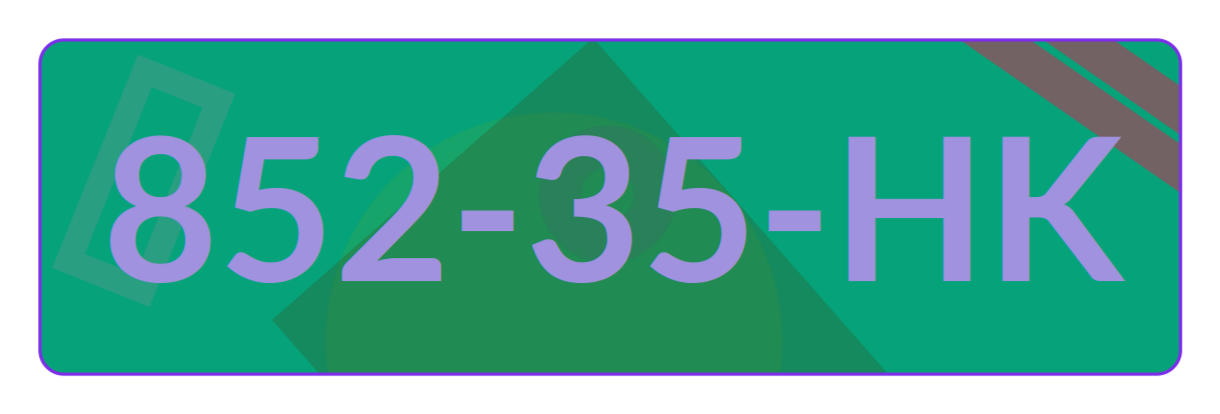

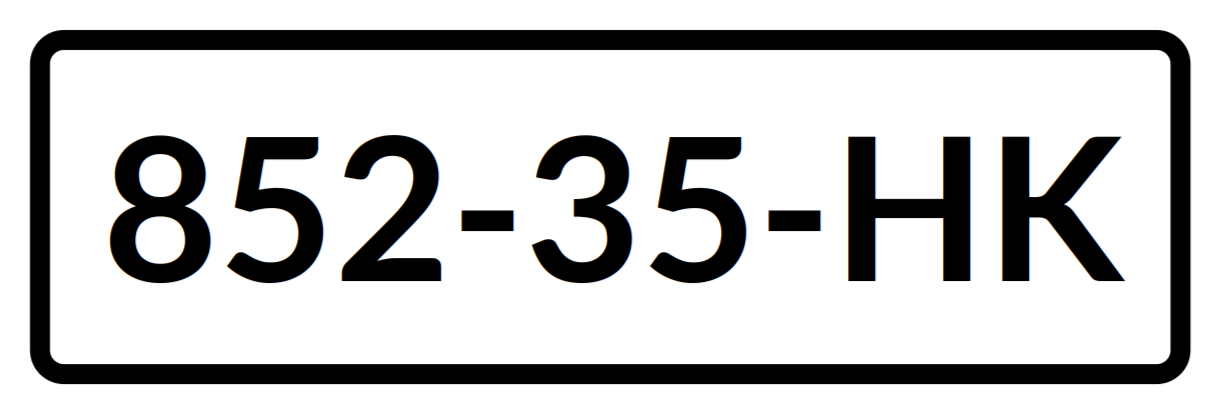

In [3942]:
display_width = 200
params = generate_plate_params()
generate_plate(params, False, f"baseline-plate.png")
generate_plate(params, True, f"highlighted-plate.png")
display(IImage('baseline-plate.png', width=display_width, height=display_width))
display(IImage('highlighted-plate.png', width=display_width, height=display_width))

In [3882]:
def gen_and_save_plate(i, _):
    random.seed(i + int(time()))
    params = generate_plate_params()
    generate_plate(params, False, f"../data/flat-plates/baseline/{i}.png")
    generate_plate(params, True, f"../data/flat-plates/highlight/{i}.png")

parallel(gen_and_save_plate, range(10000))

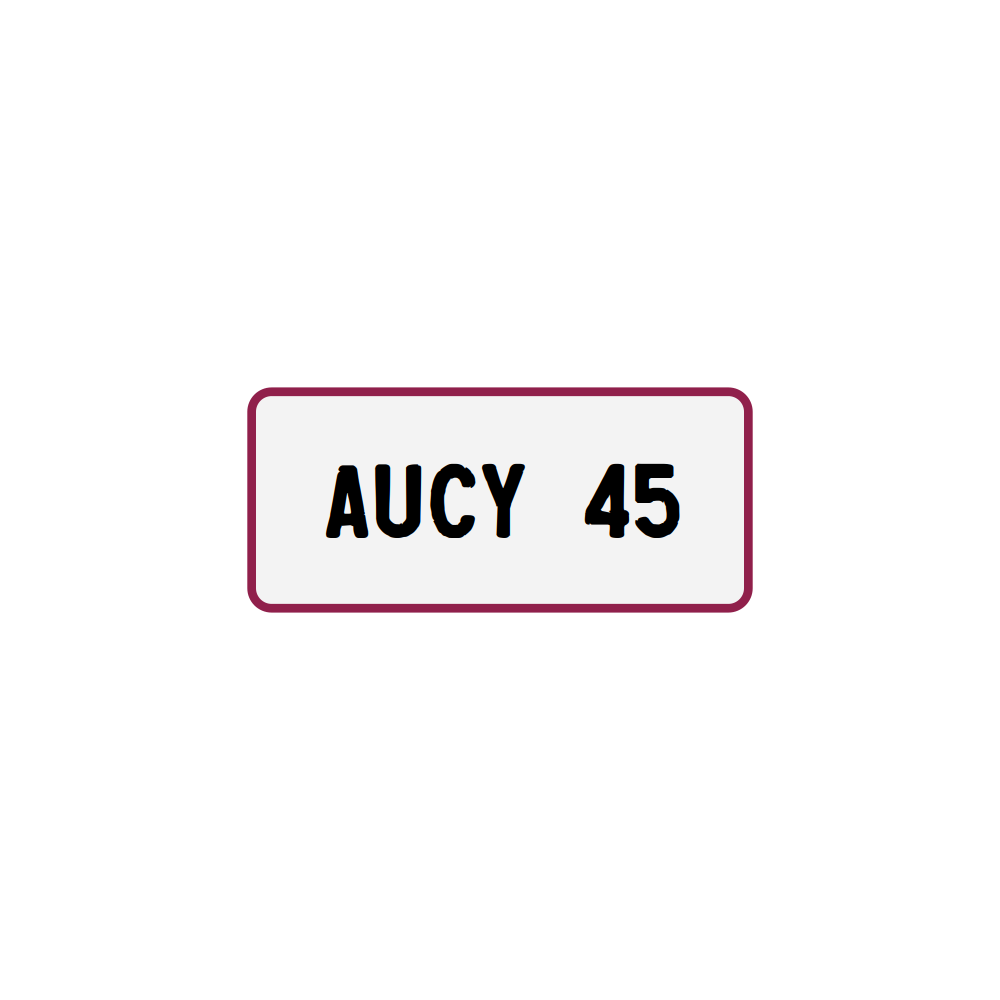

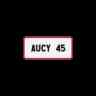

In [1970]:
# Degrade test license plate image
max_width=200
degrade_image('cairo-example.png')
display(IImage('cairo-example.png', width=max_width, height=max_width))
display(IImage('test-degrade.jpg', width=max_width, height=max_width))